In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import shutil
# shutil. rmtree(/content/HindiSeg)

In [ ]:
import codecs
import numpy as np
import os
import random
import sys
import sys
%tensorflow_version 1.8
import tensorflow as tf
import cv2
import argparse
import editdistance

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.8`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
cd /content/drive/MyDrive/Major_colab

/content/drive/MyDrive/Major_colab


In [ ]:
#  !unzip /content/drive/MyDrive/Major_training/HindiSeg.zip # only run single time

In [ ]:
filePath = '/content/drive/MyDrive'

In [ ]:
class Sample:
    "sample from the dataset"
    def __init__(self, gtText, filePath):
        self.gtText = gtText
        self.filePath = filePath
        
class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs):
        self.imgs = np.stack(imgs, axis=0) #search about stack
        self.gtTexts = gtTexts

In [ ]:
cd /content/drive/MyDrive/Major_colab

/content/drive/MyDrive/Major_colab


In [ ]:
pwd

'/content/drive/MyDrive/Major_colab'

In [ ]:
class DataLoader:

  def __init__(self, filePath, batchSize, imgSize, maxTextLen):
    "loader for dataset at given location, preprocess images and text according to parameters"

    assert filePath[-1]=='/'  # should end with '/'

    self.dataAugmentation = False
    self.currIdx = 0
    self.batchSize = batchSize
    self.imgSize = imgSize
    self.samples = []
    # use your own path and trick to read the images with the txt file
    with codecs.open(filePath+'test.txt', "r", encoding='utf-8') as f:
      lines = f.readlines()
    lines = [x.strip() for x in lines] # removing newline
    chars = set()
    #print(lines[2]) # just check what in lines
    for line in lines:
      # ignore comment line
      if not line or line[0]=='#':
        continue
      
      lineSplit = line.strip().split(' ') #split into image path and GTT

      if lineSplit[0] == '\ufeff':  # since reading first line give '\ufeff'
        continue

      fileName = lineSplit[0]

      # GT text are columns starting at 1
      gtText = self.truncateLabel(' '.join(lineSplit[1]), maxTextLen)
      chars = chars.union(set(list(gtText)))

      # check if image is not empty
      if not os.path.getsize(fileName):
        #bad_samples.append(lineSplit[0] + '.jpg')
        continue

      # put sample into list
      self.samples.append(Sample(gtText, fileName))



    # split into training and validation set: 90% - 10%
    #splitIdx = int(0.90 * len(self.samples))
    splitIdx = 4
    self.trainSamples = self.samples[:splitIdx]
    self.validationSamples = self.samples[splitIdx:]

    # put words into lists
    self.trainWords = [x.gtText for x in self.trainSamples]
    self.validationWords = [x.gtText for x in self.validationSamples]

    # number of randomly chosen samples per epoch for training 
    self.numTrainSamplesPerEpoch = 25000
    
    # start with train set
    self.trainSet()

    # list of all chars in dataset
    self.charList = sorted(list(chars))
    # 
    print("TrainSet: {}, TestSet: {}".format(len(self.trainSamples), len(self.validationSamples)))
    print("Total chars: ",len(self.charList))  # length: 109
    charList = ''.join([str(x) for x in self.charList]) #convert strings in list into a single string 
    print(self.charList)
    # uncomment if new ground truth file is added or training from scratch
    codecs.open('model/charList.txt','w', encoding='utf-8').write(charList)

  def truncateLabel(self, text, maxTextLen):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    cost = 0
    for i in range(len(text)):
      if i != 0 and text[i] == text[i-1]:
        cost += 2
      else:
        cost += 1
      if cost > maxTextLen:
        return text[:i]
    return text

  def trainSet(self):
    "switch to randomly chosen subset of training set"
    self.dataAugmentation = True
    self.currIdx = 0
    random.shuffle(self.trainSamples)
    self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]

  def validationSet(self):
    "switch to validation set"
    self.dataAugmentation = False
    self.currIdx = 0
    self.samples = self.validationSamples

  def getIteratorInfo(self):
    "current batch index and overall number of batches"
    return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)

  def hasNext(self):
    "iterator"
    print("In has next")
    print(self.currIdx , self.batchSize , len(self.samples))
    return self.currIdx + self.batchSize <= len(self.samples)
    
  def getNext(self):
    "iterator"
    batchRange = range(self.currIdx, self.currIdx + self.batchSize)
    gtTexts = [self.samples[i].gtText for i in batchRange]
    imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
    self.currIdx += self.batchSize
    return Batch(gtTexts, imgs)


In [ ]:
def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])

	# create target image and copy sample image into it
	(wt, ht) = imgSize
	(h, w) = img.shape
	fx = w / wt
	fy = h / ht
	f = max(fx, fy)
	newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
	img = cv2.resize(img, newSize)
	target = np.ones([ht, wt]) * 255
	target[0:newSize[1], 0:newSize[0]] = img

	# transpose for TF
	img = cv2.transpose(target)

	# normalize
	(m, s) = cv2.meanStdDev(img)
	m = m[0][0]
	s = s[0][0]
	img = img - m
	img = img / s if s>0 else img
	return img

In [ ]:
loader = DataLoader(filePath='data/',batchSize= 2,imgSize= (128,32),maxTextLen= 32)

TrainSet: 4, TestSet: 2
Total chars:  22
[' ', '-', 'ँ', 'ं', 'उ', 'ग', 'च', 'ज', 'त', 'न', 'ब', 'र', 'व', 'श', 'ष', 'स', 'ा', 'ी', 'ु', 'े', 'ै', '्']


In [ ]:
class FilePaths:
    "filenames and paths to data"
    fnCharList = 'model/charList.txt'
    fnAccuracy = 'model/accuracy.txt'
    fnTrain = 'data/'
    fnInfer = '../data/9.jpg'
    fnCorpus = 'data/hindi_vocab.txt'

In [ ]:
# save characters of model for inference mode
open(FilePaths.fnCharList, 'w', encoding='UTF-8').write(str().join(loader.charList))

# save words contained in dataset into file
open(FilePaths.fnCorpus, 'w', encoding='UTF-8').write(str(' ').join(loader.trainWords + loader.validationWords))

83

In [ ]:
class DecoderType:
	BestPath = 0
	BeamSearch = 1
	WordBeamSearch = 2

In [ ]:
class Model: 
    "minimalistic TF model for HTR"

    # model constants
    batchSize = 25
    imgSize = (128, 32)
    maxTextLen = 32

    def __init__(self, charList, decoderType=DecoderType.BestPath, mustRestore=False):
        "init model: add CNN, RNN and CTC and initialize TF"
        self.charList = charList
        self.decoderType = decoderType
        self.mustRestore = mustRestore
        self.snapID = 0

        # input image batch
        self.inputImgs = tf.placeholder(tf.float32, shape=(None, Model.imgSize[0], Model.imgSize[1]))
        # batch dimension set to None, it will be fixed at runtime

        # setup CNN, RNN and CTC
        self.setupCNN()
        self.setupRNN()
        self.setupCTC()

        # setup optimizer to train NN
        self.batchesTrained = 0
        self.learningRate = tf.placeholder(tf.float32, shape=[])
        self.optimizer = tf.train.RMSPropOptimizer(self.learningRate).minimize(self.loss)
        print('Learning Rate is ',self.learningRate)
        # initialize TF
        (self.sess, self.saver) = self.setupTF()


    def setupCNN(self):
        "create CNN layers and return output of these layers"
        cnnIn4d = tf.expand_dims(input=self.inputImgs, axis=3)

        # list of parameters for the layers
        kernelVals = [5, 5, 3, 3, 3]
        featureVals = [1, 32, 64, 128, 128, 256]
        strideVals = poolVals = [(2,2), (2,2), (1,2), (1,2), (1,2)]
        numLayers = len(strideVals)

        # create layers
        pool = cnnIn4d # input to first CNN layer
        for i in range(numLayers):
            kernel = tf.Variable(tf.truncated_normal([kernelVals[i], kernelVals[i], featureVals[i], featureVals[i + 1]], stddev=0.1))
            conv = tf.nn.conv2d(pool, kernel, padding='SAME',  strides=(1,1,1,1))
            relu = tf.nn.relu(conv)
            pool = tf.nn.max_pool(relu, (1, poolVals[i][0], poolVals[i][1], 1), (1, strideVals[i][0], strideVals[i][1], 1), 'VALID')

        self.cnnOut4d = pool
        print("CNN output shape:",pool.get_shape())

    def setupRNN(self):
        "create RNN layers and return output of these layers"
        rnnIn3d = tf.squeeze(self.cnnOut4d, axis=[2])

        # basic cells which is used to build RNN
        numHidden = 256
        cells = [tf.contrib.rnn.LSTMCell(num_units=numHidden, state_is_tuple=True) for _ in range(2)] # 2 layers

        # stack basic cells
        stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN
        # BxTxF -> BxTx2H
        ((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, cell_bw=stacked, inputs=rnnIn3d, dtype=rnnIn3d.dtype)

        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.truncated_normal([1, 1, numHidden * 2, len(self.charList) + 1], stddev=0.1))
        self.rnnOut3d = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=[2])

        print("RNN_OUT Shape:", self.rnnOut3d.get_shape())

    def setupCTC(self):
        "create CTC loss and decoder and return them"
        # BxTxC -> TxBxC
        self.ctcIn3dTBC = tf.transpose(self.rnnOut3d, [1, 0, 2])
        # ground truth text as sparse tensor
        self.gtTexts = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]) , tf.placeholder(tf.int32, [None]), tf.placeholder(tf.int64, [2]))

        # calc loss for batch
        self.seqLen = tf.placeholder(tf.int32, [None])
        self.loss = tf.reduce_mean(tf.nn.ctc_loss(labels=self.gtTexts, inputs=self.ctcIn3dTBC, sequence_length=self.seqLen, ctc_merge_repeated=True))

        # calc loss for each element to compute label probability
        self.savedCtcInput = tf.placeholder(tf.float32, shape=[Model.maxTextLen, None, len(self.charList) + 1])
        self.lossPerElement = tf.nn.ctc_loss(labels=self.gtTexts, inputs=self.savedCtcInput, sequence_length=self.seqLen, ctc_merge_repeated=True)

        # decoder: either best path decoding or beam search decoding
        if self.decoderType == DecoderType.BestPath:
            self.decoder = tf.nn.ctc_greedy_decoder(inputs=self.ctcIn3dTBC, sequence_length=self.seqLen)
        elif self.decoderType == DecoderType.BeamSearch:
            self.decoder = tf.nn.ctc_beam_search_decoder(inputs=self.ctcIn3dTBC, sequence_length=self.seqLen, beam_width=50, merge_repeated=False)
        elif self.decoderType == DecoderType.WordBeamSearch:
            # import compiled word beam search operation (see https://github.com/githubharald/CTCWordBeamSearch)
            word_beam_search_module = tf.load_op_library('TFWordBeamSearch.so')

            # prepare information about language (dictionary, characters in dataset, characters forming words) 
            chars = str().join(self.charList)
            wordChars = open('model/wordCharList.txt').read().splitlines()[0]
            corpus = open('data/corpus.txt').read()

            # decode using the "Words" mode of word beam search
            self.decoder = word_beam_search_module.word_beam_search(tf.nn.softmax(self.ctcIn3dTBC, dim=2), 50, 'Words', 0.0, corpus.encode('utf8'), chars.encode('utf8'), wordChars.encode('utf8'))

    def setupTF(self):
        "initialize TF"
        print('Python: '+sys.version)
        print('Tensorflow: '+tf.__version__)

        sess=tf.Session() # TF session

        saver = tf.train.Saver(max_to_keep=1) # saver saves model to file
        modelDir = 'model/'
        latestSnapshot = tf.train.latest_checkpoint(modelDir) # is there a saved model?

        # if model must be restored (for inference), there must be a snapshot
        if self.mustRestore and not latestSnapshot:
            raise Exception('No saved model found in: ' + modelDir)

        # load saved model if available
        if latestSnapshot:
            print('Init with stored values from ' + latestSnapshot)
            saver.restore(sess, latestSnapshot)
        else:
            print('Init with new values')
            sess.run(tf.global_variables_initializer())

        return (sess,saver)


    def toSparse(self, texts):
        "put ground truth texts into sparse tensor for ctc_loss"
        print("Inside the tosparse")
        print(texts)
        indices = []
        values = []
        shape = [len(texts), 0] # last entry must be max(labelList[i])

        # go over all texts
        for (batchElement, text) in enumerate(texts):
            # convert to string of label (i.e. class-ids)
            labelStr = [self.charList.index(c) for c in text]
            print(text,len(text))
            print('Label str',labelStr)
            print('Length',len(labelStr))
            print('Shape[1]',shape[1])
            # sparse tensor must have size of max. label-string
            if len(labelStr) > shape[1]:
                shape[1] = len(labelStr)
            # put each label into sparse tensor
            for (i, label) in enumerate(labelStr):
                indices.append([batchElement, i])
                values.append(label)
            print('indices',indices)
            print(values)
        return (indices, values, shape)  # for label in ctc loss


    def decoderOutputToText(self, ctcOutput, batchSize):
        "extract texts from output of CTC decoder"

        # contains string of labels for each batch element
        encodedLabelStrs = [[] for i in range(batchSize)]

        # word beam search: label strings terminated by blank
        if self.decoderType == DecoderType.WordBeamSearch:
            blank=len(self.charList)
            for b in range(batchSize):
                for label in ctcOutput[b]:
                    if label== blank:
                        break
                    encodedLabelStrs[b].append(label)


            # go over all indices and save mapping: batch -> values
            idxDict = { b : [] for b in range(batchSize) }
            for (idx, idx2d) in enumerate(decoded.indices):
                label = decoded.values[idx]
                batchElement = idx2d[0] # index according to [b,t]
                encodedLabelStrs[batchElement].append(label)

        # TF decoders: label strings are contained in sparse tensor
        else:
            # ctc returns tuple, first element is SparseTensor 
            decoded=ctcOutput[0][0] 
        # map labels to chars for all batch elements
        return [str().join([self.charList[c] for c in labelStr]) for labelStr in encodedLabelStrs]


    def trainBatch(self, batch):
        "feed a batch into the NN to train it"
        numBatchElements = len(batch.imgs)
        sparse = self.toSparse(batch.gtTexts)
        rate = 0.0001 #0.01 if self.batchesTrained < 10 else (0.001 if self.batchesTrained < 10000 else 0.0001) # decay learning rate
        evalList = [self.optimizer, self.loss]
        feedDict = {self.inputImgs : batch.imgs, self.gtTexts : sparse , self.seqLen : [Model.maxTextLen] * numBatchElements, self.learningRate : rate}
        (_, lossVal) = self.sess.run(evalList, feedDict)
        self.batchesTrained += 1
        return lossVal


    def inferBatch(self, batch, calcProbability=False, probabilityOfGT=False):
        "feed a batch into the NN to recngnize the texts"

        # decode, optionally save RNN output
        numBatchElements = len(batch.imgs)
        evalList = [self.decoder] + ([self.ctcIn3dTBC] if calcProbability else [])
        feedDict = {self.inputImgs : batch.imgs, self.seqLen : [Model.maxTextLen] * numBatchElements}
        evalRes = self.sess.run([self.decoder, self.ctcIn3dTBC], feedDict)
        decoded = evalRes[0]
        texts = self.decoderOutputToText(decoded, numBatchElements)

        # feed RNN output and recognized text into CTC loss to compute labeling probability
        probs = None
        if calcProbability:
            sparse = self.toSparse(batch.gtTexts) if probabilityOfGT else self.toSparse(texts)
            ctcInput = evalRes[1]
            evalList = self.lossPerElement
            feedDict = {self.savedCtcInput : ctcInput, self.gtTexts : sparse, self.seqLen : [Model.maxTextLen] * numBatchElements}
            lossVals = self.sess.run(evalList, feedDict)
            probs = np.exp(-lossVals)
        return (texts, probs)


    def save(self):
        "save model to file"
        self.snapID += 1
        self.saver.save(self.sess, 'model/snapshot', global_step=self.snapID)


In [ ]:
lossv = []
def validate(model, loader):
    "validate NN"
    print('Validate NN')
    loader.validationSet()
    # print(loader.samples)
    numCharErr = 0
    numCharTotal = 0
    numWordOK = 0
    numWordTotal = 0
    # print(loader.hasNext())
    while loader.hasNext():
        iterInfo = loader.getIteratorInfo()
        print('Batch:', iterInfo[0],'/', iterInfo[1])
        batch = loader.getNext()
        loss = model.trainBatch(batch)
        lossv.append(loss)

        (recognized, _) = model.inferBatch(batch)
        print(recognized)
        print('Ground truth -> Recognized')
        for i in range(len(recognized)):
            numWordOK += 1 if batch.gtTexts[i] == recognized[i] else 0
            numWordTotal += 1
            dist = editdistance.eval(recognized[i], batch.gtTexts[i])
            numCharErr += dist
            numCharTotal += len(batch.gtTexts[i])
            print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + batch.gtTexts[i] + '"', '->', '"' + recognized[i] + '"')
    loss = sum(lossv)/len(lossv)
    file1 = open("model/lossvalidation.txt", "a")  # append mode
    file1.write(str(loss)+"\n")
    file1.close()

    # print validation result
    charErrorRate = numCharErr / numCharTotal
    file1 = open("model/charerrrate.txt", "a")  # append mode
    file1.write(str(charErrorRate)+"\n")
    file1.close()

    wordAccuracy = numWordOK / numWordTotal
    file1 = open("model/accuracyvalidation.txt", "a")  # append mode
    file1.write(str(wordAccuracy)+"\n")
    file1.close()
    print('Character error rate: %f%%. Word accuracy: %f%%.' % (charErrorRate*100.0, wordAccuracy*100.0))
    return charErrorRate

In [ ]:

def train(model, loader):
    "train NN"
    epoch = 0 # number of training epochs since start
    bestCharErrorRate = float('inf') # best valdiation character error rate
    noImprovementSince = 0 # number of epochs no improvement of character error rate occured
    earlyStopping = 5 # stop training after this number of   epochs without improvement
    while True:
        losst = []
        epoch += 1
        print('Epoch:', epoch)

        # train
        print('Train NN')
        loader.trainSet()
        numCharErr = 0
        numCharTotal = 0
        numWordOK = 0
        numWordTotal = 0
        while loader.hasNext():
            iterInfo = loader.getIteratorInfo()
            batch = loader.getNext()
            loss = model.trainBatch(batch)
            print('Batch:', iterInfo[0],'/', iterInfo[1], 'Loss:', loss)
            losst.append(loss)
            (recognized, _) = model.inferBatch(batch)
            # 
            for i in range(len(recognized)):
              numWordOK += 1 if batch.gtTexts[i] == recognized[i] else 0
              numWordTotal += 1
              dist = editdistance.eval(recognized[i], batch.gtTexts[i])
              numCharErr += dist
              numCharTotal += len(batch.gtTexts[i])
              print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + batch.gtTexts[i] + '"', '->', '"' + recognized[i] + '"')
            # 
        wordAccuracy = numWordOK / numWordTotal
        file1 = open("model/accuracytrain.txt", "a")  # append mode
        file1.write(str(wordAccuracy)+"\n")
        file1.close()   
        loss = sum(losst)/len(losst)
        file1 = open("model/losstrain.txt", "a")  # append mode
        file1.write(str(loss)+"\n")
        file1.close()


        # validate
        charErrorRate = validate(model, loader)

        # if best validation accuracy so far, save model parameters
        if charErrorRate < bestCharErrorRate:
            print('Character error rate improved, save model')
            bestCharErrorRate = charErrorRate
            noImprovementSince = 0
            model.save()
            open(FilePaths.fnAccuracy, 'w').write('Validation character error rate of saved model: %f%%' % (charErrorRate*100.0))
        else:
            print('Character error rate not improved')
            noImprovementSince += 1

        # stop training if no more improvement in the last x epochs
        if noImprovementSince >= earlyStopping:
            print('No more improvement since %d epochs. Training stopped.' % earlyStopping)
            break

In [ ]:
decoderType = DecoderType.BestPath
model = Model(loader.charList, decoderType) #0 --> best path

CNN output shape: (?, 32, 1, 256)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer 

In [ ]:
train(model, loader)

Epoch: 1
Train NN
In has next
0 2 4
Inside the tosparse
['ग ै र - च ु न ा व ी', 'र ं ग र े ज व ा']
ग ै र - च ु न ा व ी 19
Label str [5, 0, 20, 0, 11, 0, 1, 0, 6, 0, 18, 0, 9, 0, 16, 0, 12, 0, 17] 19
Length 19
Shape[1] 0
indices [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18]]
[5, 0, 20, 0, 11, 0, 1, 0, 6, 0, 18, 0, 9, 0, 16, 0, 12, 0, 17]
र ं ग र े ज व ा 15
Label str [11, 0, 3, 0, 5, 0, 11, 0, 19, 0, 7, 0, 12, 0, 16] 15
Length 15
Shape[1] 19
indices [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14]]
[5, 0, 20, 0, 11, 0, 1, 0, 6, 0, 18, 0, 9, 0, 16, 0, 12, 0, 17, 11, 0, 3, 0, 5, 0, 11, 0, 19, 0, 7, 0, 12, 0, 16]
Batch: 1 / 2 Loss: 35.932404
[ER

''

Practice of all..

In [ ]:
loader.

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 5), (7, 3), (8, 6), (9, 2)]


In [ ]:
sess=tf.Session() # TF session
saver = tf.train.Saver(max_to_keep=1)
modelDir = 'model/'
latestSnapshot = tf.train.latest_checkpoint(modelDir)

In [ ]:
print(latestSnapshot)
print(not latestSnapshot)

model/snapshot-1
False


In [ ]:
texts.index(5)

4

In [ ]:
x= [[] for i in range(9)]

In [ ]:
x[1] = [1,3,4]

In [ ]:
x

[[], [1, 3, 4], [], [], [], [], [], [], []]

In [ ]:
def preprocess(img, imgSize, dataAugmentation=False):
  "put img into target img of size imgSize, transpose for TF and normalize gray-values"

  # there are damaged files in IAM dataset - just use black image instead
  if img is None:
    img = np.zeros([imgSize[1], imgSize[0]])

  # create target image and copy sample image into it
  (wt, ht) = imgSize
  (h, w) = img.shape
  print('shape of image',img.shape)
  print('target shape',wt,ht)
  fx = w / wt
  fy = h / ht
  f = max(fx, fy)
  print('fx fy f',fx,fy,f)
  newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
  print('newsize',newSize)
  img = cv2.resize(img, newSize)
  target = np.ones([ht, wt]) * 255
  target[0:newSize[1], 0:newSize[0]] = img
  print('target shape',target.shape)

  # transpose for TF
  img = cv2.transpose(target)
  print('transpose shape',img.shape)
  # normalize
  (m, s) = cv2.meanStdDev(img)
  m = m[0][0]
  s = s[0][0]
  img = img - m
  img = img / s if s>0 else img
  return img

In [ ]:
preprocess(cv2.imread('/content/drive/MyDrive/Major_colab/HindiSeg/train/1/1/1.jpg', cv2.IMREAD_GRAYSCALE),(128,32))

shape of image (293, 713)
target shape 128 32
fx fy f 5.5703125 9.15625 9.15625
newsize (77, 32)
target shape (32, 128)
transpose shape (128, 32)


array([[-0.57068973, -0.15483659, -0.18949102, ..., -0.25879988,
        -0.39741759, -0.29345431],
       [-0.36276316, -0.29345431, -0.12018217, ..., -0.25879988,
        -0.25879988, -0.32810873],
       [-0.32810873, -0.22414545, -0.22414545, ..., -0.29345431,
        -0.25879988, -0.36276316],
       ...,
       [ 0.91945067,  0.91945067,  0.91945067, ...,  0.91945067,
         0.91945067,  0.91945067],
       [ 0.91945067,  0.91945067,  0.91945067, ...,  0.91945067,
         0.91945067,  0.91945067],
       [ 0.91945067,  0.91945067,  0.91945067, ...,  0.91945067,
         0.91945067,  0.91945067]])

In [ ]:
''.join(['a','e','i','o','u'])

'aeiou'

In [ ]:
str().join(loader.charList)

' -ँंःअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसह़ऽािीुूृॄॅेैॉॊोौ्ॐ॒॑॓॔क़ख़ग़ज़ड़ढ़फ़य़ॠॢ।०१२३४५६७८९॰ॱॲॻॼॽॾ'

In [ ]:
loader.charList

[' ',
 '-',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ऌ',
 'ऍ',
 'ऎ',
 'ए',
 'ऐ',
 'ऑ',
 'ऒ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'ऩ',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ऱ',
 'ल',
 'ळ',
 'ऴ',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ऽ',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'ॄ',
 'ॅ',
 'े',
 'ै',
 'ॉ',
 'ॊ',
 'ो',
 'ौ',
 '्',
 'ॐ',
 '॑',
 '॒',
 '॓',
 '॔',
 'क़',
 'ख़',
 'ग़',
 'ज़',
 'ड़',
 'ढ़',
 'फ़',
 'य़',
 'ॠ',
 'ॢ',
 '।',
 '०',
 '१',
 '२',
 '३',
 '४',
 '५',
 '६',
 '७',
 '८',
 '९',
 '॰',
 'ॱ',
 'ॲ',
 'ॻ',
 'ॼ',
 'ॽ',
 'ॾ']

In [ ]:
import tensorflow as tf
model.layers

AttributeError: ignored

In [ ]:
lst = [1,2,3,4]
sum(lst)/len(lst)
pwd

NameError: ignored

In [ ]:
l =10
file1 = open("model/losstrain.txt", "a")  # append mode
file1.write(str(l)+ "\n")
file1.close()


In [ ]:
file1 = open("model/abc.txt", "a")
file1.write(str(12)+"\n")
file1.close()  
file1 = open("model/abc.txt", "a")
file1.write(str(19)+"\n")
file1.close()    


In [ ]:
with codecs.open('model/abc.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [int(i) for i in lines] #convert to integer
  #print(lines[2]) # just check what in lines
  print(lines)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
# y=np.array(lines)
# x=np.array(range(len(lines)))
# plt.plot(x,y)
# plt.title("Traning and validation Loss ")
# plt.xlabel("No of Epoch")
# plt.ylabel("Loss")
# # plt.plot(x,label='Epoch', linestyle = 'dotted')
# # plt.plot(y,label='accuracy',linestyle = 'dashed')

# # line 1 points
x1 = range(len(lines))
y1 = lines
# plotting the line 1 points
plt.plot(x1, y1, label = "Train Loss")
 
# line 2 points
x2 = range(len(lines))
y2 = [4,1]
# plotting the line 2 points
plt.plot(x2, y2, label = "Validation Loss")
 
# naming the x axis
plt.xlabel('No of Epoch')
# naming the y axis
plt.ylabel('Loss')
# giving a title to my graph
plt.title('Traning and validation Loss')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()
plt.show()


NameError: ignored

In [ ]:
with codecs.open('model/accuracytrain.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [float(i) for i in lines] #convert to float
  #print(lines[2]) # just check what in lines
  accuracy_train = lines
with codecs.open('model/accuracyvalidation.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [float(i) for i in lines] #convert to float
  #print(lines[2]) # just check what in lines
  accuracy_validation = lines

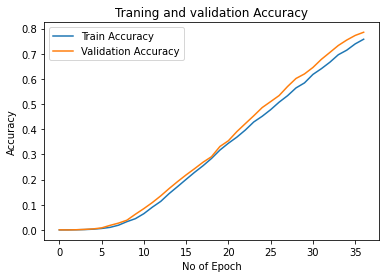

In [ ]:
import matplotlib.pyplot as plt
# # line 1 points
x1 = range(len(accuracy_train))
y1 = accuracy_train
# plotting the line 1 points
plt.plot(x1, y1, label = "Train Accuracy")
 
# line 2 points
x2 = range(len(accuracy_validation))
y2 = accuracy_validation
# plotting the line 2 points
plt.plot(x2, y2, label = "Validation Accuracy")
 
# naming the x axis
plt.xlabel('No of Epoch')
# naming the y axis
plt.ylabel('Accuracy')
# giving a title to my graph
plt.title('Traning and validation Accuracy')
 
# show a legend on the plot
plt.legend()
plt.savefig('plotaccuracy.png', dpi=300, bbox_inches='tight')
# function to show the plot
plt.show()
plt.show()

In [ ]:
del accuracy_validation[0]

In [ ]:
with codecs.open('model/losstrain.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [float(i) for i in lines] #convert to float
  #print(lines[2]) # just check what in lines
  loss_train = lines
with codecs.open('model/lossvalidation.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [float(i) for i in lines] #convert to float
  #print(lines[2]) # just check what in lines
  loss_validation = lines

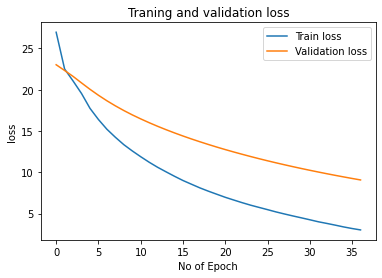

In [ ]:
import matplotlib.pyplot as plt
# # line 1 points
x1 = range(len(loss_train))
y1 = loss_train
# plotting the line 1 points
plt.plot(x1, y1, label = "Train loss")
 
# line 2 points
x2 = range(len(loss_validation))
y2 = loss_validation
# plotting the line 2 points
plt.plot(x2, y2, label = "Validation loss")
 
# naming the x axis
plt.xlabel('No of Epoch')
# naming the y axis
plt.ylabel('loss')
# giving a title to my graph
plt.title('Traning and validation loss')
 
# show a legend on the plot
plt.legend()
plt.savefig('plotloss.png', dpi=300, bbox_inches='tight')
# function to show the plot
plt.show()
plt.show()

In [ ]:
with codecs.open('model/charerrrate.txt', "r", encoding='utf-8') as f:
  lines = f.readlines()
  lines = [x.strip() for x in lines] # removing newline
  lines = [float(i) for i in lines] #convert to float
  #print(lines[2]) # just check what in lines
  char_errrate= lines

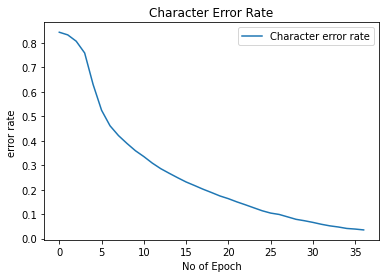

In [ ]:
import matplotlib.pyplot as plt
# # line 1 points
x1 = range(len(char_errrate))
y1 = char_errrate
# plotting the line 1 points
plt.plot(x1, y1, label = "Character error rate")
 
 
# naming the x axis
plt.xlabel('No of Epoch')
# naming the y axis
plt.ylabel('error rate ')
# giving a title to my graph
plt.title('Character Error Rate')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.savefig('plotCER.png', dpi=300, bbox_inches='tight')
plt.show()
plt.show()

In [ ]:
# latestSnapshot = tf.train.latest_checkpoint(modelDir)
# latestSnpshot

In [ ]:
# import editdistance
# commands = ['बन्द गर्नु','खोल्नु','अवस्ता बताउनु'] 
# user_command = input('कमाण्ड दिनुहोस ')
# distances= []

# for count,command in enumerate(commands):
#   distance = editdistance.eval(user_command, command)
#   distances.append(distance)
# print(distances)
# min_value = min(distances)
# min_index = distances.index(min_value) 

# print('Nearsest command is',commands[min_index])



कमाण्ड दिनुहोस अवस्ता
[9, 5, 7]
Nearsest command is खोल्नु


In [ ]:
shp = [12,0]

In [ ]:
shp

[12, 0]